# Week 1 : Systematically Improving Your RAG

## Starting with Retrieval Metrics

When developing your RAG application, it's easy to start evaluating the generated content and do a vibe check. However, this can be challenging to scale and costly to implement. Instead, it's much more efficient to start with retrieval evals.

By focusing specifically on precision and recall, we can objectively measure how well our retrieval system is performing and support several initial use cases early on. 

$$ \text{Precision} = \frac{\text{Number of Relevant Items Retrieved}}{\text{Total Number of Retrieved Items}} $$ 


$$ \text{Recall} = \frac{\text{Number of Relevant Items Retrieved}}{\text{Total Number of Relevant Items}} $$ 

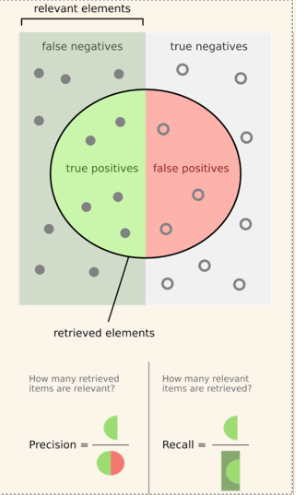


These metrics are relatively inexpensive and straightforward to compute. This means that we can iterate much faster, more efficiently and establish a strong foundation for our RAG application.

 
| Test | Generation evals | Retrieval evals |
|--------|------------------|-----------------|
| Metrics | Team lead: "Looks better now" (based on metric evaluations that don't capture usage behavior) | Recall, precision@K |
| Speed | Slow (~1s to 10s per test) | Fast (~10ms to 800ms per test) |
| Cost | $100s per run | Negligible per run |
| Frequency | Infrequent | Frequent |
| Iteration | Slow iterations (tests that could take minutes to hours) | Fast iterations |
| Ease | Difficult | Easy |

This is the first in 3 notebooks where we'll be using synthetic data generation to evaluate our RAG application. We'll do so by generating synthetic questions, running evaluations on different retrieval configurations before finally looking at how to visualise and reason about the results. This is crucial for you to be able to iterate on your own retrieval system and improve it.


## Synthetic Questions

Since we may not have access to real user queries initially, generating synthetic questions allows us to simulate potential user interactions with our system. This approach helps us establish a performance baseline for our retrieval system and identify any retrieval issues early on, ensuring that our system is robust before deployment. 

This is a never-ending process. Once you do get user traffic, you'll want to keep generating more synthetic questions and start blending in user queries to make sure your system's retrieval is still doing well.



# Evaluating Retrieval

Consider an example where we're trying to build a Text-2-SQL application. This is an application where we take in a user query and output a SQL query which can be used to retrieve the relevant information as seen below.

```
Text : Hey could you help me find the top 5 most popular items in our store?
Query: SELECT item_name, COUNT(*) as popularity FROM items GROUP BY item_name ORDER BY popularity DESC LIMIT 5
```

This feels like a generation task but ultimately can be greatly improved by including few-shot examples. This is very similar to how we might look for relevant text chunks in a classic Question Answer RAG application.

However,by framing this as a retrieval task, we can start by looking at precision and recall of our retrieval system before we even start looking at the generated SQL queries. This has two main benefits.

1. When we do evaluate the generated SQL queries, we can identify edge cases early on and add them to our list of snippets. We can then verify that these few shot examples are retrieved when we encounter these questions to help generate better SQL snippets.
2. Different companies have unique business logic or calculation methods. Being able to retrieve the relevant snippets when these specific measurements are required is crucial. 


## Case Study : Bird-Bench

For this case-study, we'll be using the Bird-Bench dataset. This is a huge Text-2-SQL dataset which contains a collection of text questions to a corresponding sql query. 

We'll be using the dev split of this dataset for this case study that provides ~1500+ sql snippets that involves ~95 different tables that we can use. 

We've cleaned the dataset ahead of time and uploaded it to `567-labs/bird-rag`. Each example in our dataset contains three things

- `id` : This is a unique identifier for each query
- `query` : This is a sample SQL query 
- `difficulty` : This is a label that indicates how difficult the query is to generate. It can be either `simple`, `moderate` or `challenging`. 

For this case study, we'll only be using the `challenging` queries so that we can generate more difficult questions. This allows us to test our retrieval system under more demanding conditions, ensuring that it performs well even with complex queries

With that in mind, let's take a look at our dataset

In [1]:
import datasets

dataset = datasets.load_dataset("567-labs/bird-rag")["train"]
dataset[0]

{'id': '0',
 'query': "SELECT `Free Meal Count (K-12)` / `Enrollment (K-12)` FROM frpm WHERE `County Name` = 'Alameda' ORDER BY (CAST(`Free Meal Count (K-12)` AS REAL) / `Enrollment (K-12)`) DESC LIMIT 1",
 'difficulty': 'simple'}

Before we generate questions, let's take a look at what a synthetic question might look like by looking at our query below.

> SELECT `Free Meal Count (K-12)` / `Enrollment (K-12)` FROM frpm WHERE `County Name` = 'Alameda' ORDER BY (CAST(`Free Meal Count (K-12)` AS REAL) / `Enrollment (K-12)`) DESC LIMIT 1


We can see that this query is doing a few things

1. First it's looking at the percentage of students that are recieving free meals 
2. It's restricting this to only schools in Alameda County
3. Finally, it's ordering the results by this percentage in descending order and limiting the results to the top 1

In short, it's trying to find the school in Alameda County with the highest percentage of students recieving free meals. So, what would be a potential question that we could ask which this query snippet would be highly relevant for?

Well, a potential question could be

- What is the school with the highest percentage of students recieving free meals in Alameda County?
- What were the two schools with the highest percentage of students recieving free meals in Orange County last year?

These are queries which this snippet would be highly relevant for. We want to create a dataset of similar questions that would be able to test how consistently our retrieval system does at retrieving the relevant snippet for a user query.

## Generating Synthetic Questions

Now let's start generating our synthetic questions. We're going to begin by defining some Pydantic models that represent the format of the data that we're working with.

We're doing so because of the following reasons

1. It helps us to be explicit about the data we're working with 
2. We can use these models with the `instructor` library to obtain structured outputs from our LLM calls


In [12]:
from pydantic import BaseModel


# This represents how we're representing our data from the dataset
class Chunk(BaseModel):
    chunk_id: str
    text: str


# This is the synthetic question that we want our model to generate
class Question(BaseModel):
    chain_of_thought: str
    question: str


# This is a single question-chunk pair that we'll be uploading to Braintrust as a dataset later on to be used for benchmarking in `benchmark_retrieval.py`
class ChunkEval(BaseModel):
    chunk_id: str
    question: str
    chunk: str

We're using `instructor` because it handles prompt templating with `jinja` for us and provides validated structured outputs. 

All we need to do is to define a Pydantic model that represents a desired output and the library will handle the rest. 

Remember that we want to generate a question that should either be answerable by the data returned by the SQL snippet directly or with some small tweaks.



In [49]:
import openai
import instructor
from asyncio import Semaphore, timeout
from tqdm.asyncio import tqdm_asyncio as asyncio
from tenacity import retry, stop_after_attempt, wait_fixed

client = instructor.from_openai(openai.OpenAI())

sql_snippet = "SELECT `Free Meal Count (K-12)` / `Enrollment (K-12)` FROM frpm WHERE `County Name` = 'Alameda' ORDER BY (CAST(`Free Meal Count (K-12)` AS REAL) / `Enrollment (K-12)`) DESC LIMIT 1"

resp = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {
            "role": "user",
            "content": """
        Generate a hypothetical question that can be answered using the following SQL snippet. 

        SQL Snippet:
        {{ snippet }}

        Rules
        - If there are specific values in the snippet, do not use them directly in the question if possible. 
        - The question should be at most 2 sentences long
        - if necessary, consider making the question more challenging using the following constraint - If there's a time period mentioned in the snippet, modify it slightly (Eg. if the snippet is looking at the entire year, change it to 6 months or 1.5 years)
        - The question must be answerable using the SQL snippet or at most with a small tweak
        """,
        }
    ],
    response_model=Question,
    context={"snippet": sql_snippet},
)

resp.question

'What is the highest ratio of free meal counts to total enrollments in K-12 schools for a specific county over a recent semester?'

> ''What is the highest ratio of free meal counts to total enrollments in K-12 schools for a specific county over a recent semester?'


This is a question which the SQL snippet would be highly relevant for. In order to answer this query, we just need to make two changes

1. add in a new time filter of a recent semester
2. change the county to a variable

### Why is synthetic data generation difficult?

We cannot use the same prompt and expect a diverse set of questions. Therefore we need to introduce slight variations in the prompt to generate questions that are different in wording, intent and content. This is crucial in identifying blindspots in our retrieval system. 

In the example below, we're using the same prompt but introducing randomly chosen constraints at each point. This forces the model to write and generate different questions each time, allowing us to collect a more diverse set of questions. The key here is to really introduce different sources of variation when doing these generations.

## Scaling Up Our Questions

With those points in mind, let's scale our question generation up.

We'll do so by generating a question for each SQL snippet marked as challenging. Since this will be a large number of requests, we're going to be doing so asynchronously with the `asyncio` library.

Additionally, to make sure we stay within our rate limits , we'll be using a semaphore to limit the number of concurrent requests.

We're also making sure that we have a good diversity of questions by randomly selecting a constraint from a set of constraints to make the question more challenging.

In [41]:
import random

# Define Instructor Client
client = instructor.from_openai(openai.AsyncOpenAI())

# Define some constraints to make the question more challenging
constraints = [
    "If there's a time period mentioned in the snippet, modify it slightly (Eg. if the snippet is looking at the entire year, change it to 6 months or 1.5 years)",
    "Add in some irrelevant context (Eg. Add information about the weather, a random event or a backstory that isn't mentioned in the snippet)",
    "Changing the value of the filter (Eg. if the snippet is looking at the results in Canada, change the question to ask about another country or city instead)",
]


@retry(stop=stop_after_attempt(3), wait=wait_fixed(10))
async def generate_questions(chunk: Chunk, sem: Semaphore) -> ChunkEval:
    async with sem, timeout(30):
        resp = await client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {
                    "role": "user",
                    "content": """
                Generate a hypothetical question that can be answered using the following SQL snippet. 

                SQL Snippet:
                {{ snippet }}

                Rules
                - If there are specific values in the snippet, do not use them directly in the question if possible. 
                - The question should be at most 2 sentences long
                - if necessary, consider making the question more challenging using the following constraint - {{ constraint }}
                - The question must be answerable using the SQL snippet or at most with a small tweak
                """,
                }
            ],
            response_model=Question,
            context={"snippet": chunk.text, "constraint": random.choice(constraints)},
        )

        return ChunkEval(
            chunk_id=chunk.chunk_id,
            question=resp.question,
            chunk=chunk.text,
        )


sem = Semaphore(10)
dataset = [
    item
    for item in datasets.load_dataset("567-labs/bird-rag")["train"]
    if item["difficulty"] == "challenging"
]
dataset = [Chunk(chunk_id=item["id"], text=item["query"]) for item in dataset]

coros = []

num_samples = 2
for chunk in dataset:
    for _ in range(num_samples):
        coros.append(generate_questions(chunk, sem))

questions: list[ChunkEval] = await asyncio.gather(*coros)

100%|██████████| 290/290 [01:02<00:00,  4.62it/s]


Now that we've generated our questions, let's take a look at what they look like.

In [44]:
from rich import print


for i in range(2):
    print(f"""
    Question: {questions[i].question}

    SQL Snippet: {questions[i].chunk}
    """)

Question: In the past year, which locally funded schools have an enrollment difference between K-12 and ages 
5-17 that exceeds the average difference among their peers?

    SQL Snippet: SELECT T2.School, T2.DOC FROM frpm AS T1 INNER JOIN schools AS T2 ON T1.CDSCode = T2.CDSCode WHERE
T2.FundingType = 'Locally funded' AND (T1.`Enrollment (K-12)` - T1.`Enrollment (Ages 5-17)`) > (SELECT 
AVG(T3.`Enrollment (K-12)` - T3.`Enrollment (Ages 5-17)`) FROM frpm AS T3 INNER JOIN schools AS T4 ON T3.CDSCode = 
T4.CDSCode WHERE T4.FundingType = 'Locally funded')

Question: Which schools in France are locally funded and have a greater difference between their total K-12 
enrollment and enrollment for ages 5-17 compared to the average difference for locally funded schools?

    SQL Snippet: SELECT T2.School, T2.DOC FROM frpm AS T1 INNER JOIN schools AS T2 ON T1.CDSCode = T2.CDSCode WHERE
T2.FundingType = 'Locally funded' AND (T1.`Enrollment (K-12)` - T1.`Enrollment (Ages 5-17)`) > (SELECT 
AVG(T3.`Enrollment (K-12)` - T3.`Enrollment (Ages 5-17)`) FROM frpm AS T3 INNER JOIN schools AS T4 ON T3.CDSCode = 
T4.CDSCode WHERE T4.FundingType = 'Locally funded')

If we look at both of the generated questions, they're essentially asking about the same thing - that is the schools that are locally funded and have an enrollment difference that's above average.

However, despite so, they have different wording.

The first has a time frame of 1 year while the second one is looking at schools in France specifically. This is a small change but it's enough to create diversity in our questions.

We can scale this up further by adding more constraints and generating more questions. This is crucial in uncovering blindspots in our retrieval system.

## Sharing with the team

If you're working with a team, it's incredibly important to be able to share the results of the experiments with them. In this course, we'll be using [Braintrust](https://www.braintrust.dev/) because it provides an easy way to store private datasets that we can use for benchmarking our retrieval. 

In [43]:
import braintrust

# Initialise Braintrust Dataset
dataset = braintrust.init_dataset(project="Text-2-SQL", name="Bird-Bench-Questions")

# Insert Individual Questions row by row
for question in questions:
    dataset.insert(
        input=question.question,
        expected=[question.chunk],
        metadata={"chunk_id": question.chunk_id, "chunk": question.chunk},
    )

print(dataset.summarize())

DatasetSummary(
    project_name='Text-2-SQL',
    dataset_name='Bird-Bench-Questions',
    project_url='https://www.braintrust.dev/app/567/p/Text-2-SQL',
    dataset_url='https://www.braintrust.dev/app/567/p/Text-2-SQL/datasets/Bird-Bench-Questions',
    data_summary=DataSummary(new_records=290, total_records=290)
)